# Remaining Useful Life Prediction  
## Data Loading and Preprocessing (NASA C-MAPSS)

This notebook focuses on the prediction of the **Remaining Useful Life (RUL)** of aircraft engines using the NASA **C-MAPSS** benchmark datasets.

The objective is to build a complete and reproducible machine learning pipeline, starting from raw data loading and preprocessing, and leading to the training and evaluation of predictive models.

Three datasets are considered:

- **FD001**: single operating condition, single fault mode  
- **FD002**: multiple operating conditions, single fault mode  
- **FD003**: single operating condition, multiple fault modes  

Each dataset is composed of:
- a **training set** containing full run-to-failure trajectories,
- a **test set** containing truncated trajectories,
- a **RUL file** providing the true Remaining Useful Life for the last cycle of each test engine.

Each row in the datasets corresponds to one operating cycle of an engine and includes:
- an engine identifier,
- a cycle index,
- operational settings,
- multiple sensor measurements.

This section is dedicated to **data loading, inspection, and preprocessing**, which are essential steps before model training and evaluation.


In [40]:
import numpy as np
import pandas as pd

# Colonnes communes à tous les jeux C-MAPSS
cols = (
    ['unit', 'cycle']
    + [f'op_{i}' for i in range(1, 4)]
    + [f's_{i}' for i in range(1, 22)]
)

# ======================
# FD001
# ======================
train  = pd.read_csv("train_FD001.txt", sep=r"\s+", header=None, names=cols)
test   = pd.read_csv("test_FD001.txt",  sep=r"\s+", header=None, names=cols)
rul    = pd.read_csv("RUL_FD001.txt",   sep=r"\s+", header=None, names=["RUL"])

# ======================
# FD002
# ======================
train2 = pd.read_csv("train_FD002.txt", sep=r"\s+", header=None, names=cols)
test2  = pd.read_csv("test_FD002.txt",  sep=r"\s+", header=None, names=cols)
rul2   = pd.read_csv("RUL_FD002.txt",   sep=r"\s+", header=None, names=["RUL"])

# ======================
# FD003
# ======================
train3 = pd.read_csv("train_FD003.txt", sep=r"\s+", header=None, names=cols)
test3  = pd.read_csv("test_FD003.txt",  sep=r"\s+", header=None, names=cols)
rul3   = pd.read_csv("RUL_FD003.txt",   sep=r"\s+", header=None, names=["RUL"])

# ======================
# Vérification rapide
# ======================

print("FD001:", train.shape, test.shape, rul.shape)
print("FD002:", train2.shape, test2.shape, rul2.shape)
print("FD003:", train3.shape, test3.shape, rul3.shape)



FD001: (20631, 26) (13096, 26) (100, 1)
FD002: (53759, 26) (33991, 26) (259, 1)
FD003: (24720, 26) (16596, 26) (100, 1)


In [3]:
import sys, sklearn, tensorflow as tf
print(sys.executable)
print("sklearn:", sklearn.__version__)
print("tf:", tf.__version__)



c:\Users\mantr\AppData\Local\Programs\Python\Python311\python.exe
sklearn: 1.4.2
tf: 2.15.1


## Dataset verification and consistency check

After loading the FD001, FD002, and FD003 datasets, a quick consistency check is performed by displaying the shapes of the training sets, test sets, and RUL files.

This verification confirms that:
- each training set contains full run-to-failure trajectories,
- each test set contains truncated engine trajectories,
- the RUL files provide one target value per test engine.

The observed dataset sizes reflect the differences between the C-MAPSS scenarios:
- **FD001**: single operating condition and single fault mode,
- **FD002**: multiple operating conditions and single fault mode, leading to a larger number of engines and cycles,
- **FD003**: single operating condition with multiple fault modes.

Displaying the first rows of the FD001 training set allows us to verify that the data structure is correct and that all variables (engine identifier, cycle index, operational settings, and sensor measurements) are properly formatted.


In [4]:
import pandas as pd

# Colonnes communes à tous les jeux C-MAPSS
cols = (
    ["unit_nr", "cycle"] +
    [f"op_setting_{i}" for i in range(1, 4)] +
    [f"s{i}" for i in range(1, 22)]
)

# ======================
# FD001
# ======================
df_train  = pd.read_csv("train_FD001.txt", sep=r"\s+", header=None, names=cols)
df_test   = pd.read_csv("test_FD001.txt",  sep=r"\s+", header=None, names=cols)
df_rul    = pd.read_csv("RUL_FD001.txt",   sep=r"\s+", header=None, names=["RUL"])

# ======================
# FD002
# ======================
df_train2 = pd.read_csv("train_FD002.txt", sep=r"\s+", header=None, names=cols)
df_test2  = pd.read_csv("test_FD002.txt",  sep=r"\s+", header=None, names=cols)
df_rul2   = pd.read_csv("RUL_FD002.txt",   sep=r"\s+", header=None, names=["RUL"])

# ======================
# FD003
# ======================
df_train3 = pd.read_csv("train_FD003.txt", sep=r"\s+", header=None, names=cols)
df_test3  = pd.read_csv("test_FD003.txt",  sep=r"\s+", header=None, names=cols)
df_rul3   = pd.read_csv("RUL_FD003.txt",   sep=r"\s+", header=None, names=["RUL"])

# ======================
# Vérification rapide
# ======================
print("FD001:", df_train.shape,  df_test.shape,  df_rul.shape)
print("FD002:", df_train2.shape, df_test2.shape, df_rul2.shape)
print("FD003:", df_train3.shape, df_test3.shape, df_rul3.shape)






FD001: (20631, 26) (13096, 26) (100, 1)
FD002: (53759, 26) (33991, 26) (259, 1)
FD003: (24720, 26) (16596, 26) (100, 1)


In [5]:
# ===============================
# RUL construction (FD001/FD002/FD003)
# ===============================

def add_rul_train(df_train):
    """TRAIN: RUL = max_cycle(unit) - cycle"""
    max_cycle = df_train.groupby("unit_nr")["cycle"].max()
    df_train = df_train.copy()
    df_train["RUL"] = df_train["unit_nr"].map(max_cycle) - df_train["cycle"]
    return df_train

def add_rul_test(df_test, df_rul):
    """
    TEST: RUL(t) = (max_cycle_test(unit) - cycle) + RUL_final(unit)
    where RUL_final comes from RUL_FD00X.txt (one value per engine)
    """
    max_cycle_test = df_test.groupby("unit_nr")["cycle"].max()
    rul_map = {i + 1: v for i, v in enumerate(df_rul["RUL"].values)}
    df_test = df_test.copy()
    df_test["RUL"] = (
        df_test["unit_nr"].map(max_cycle_test)
        - df_test["cycle"]
        + df_test["unit_nr"].map(rul_map)
    )
    return df_test

# ---------- FD001 ----------
df_train  = add_rul_train(df_train)
df_test   = add_rul_test(df_test, df_rul)

# ---------- FD002 ----------
df_train2 = add_rul_train(df_train2)
df_test2  = add_rul_test(df_test2, df_rul2)

# ---------- FD003 ----------
df_train3 = add_rul_train(df_train3)
df_test3  = add_rul_test(df_test3, df_rul3)

# ===============================
# Quick checks
# ===============================
print("FD001 RUL check:", df_train["RUL"].min(), df_train["RUL"].max(), "| test:", df_test["RUL"].min(), df_test["RUL"].max())
print("FD002 RUL check:", df_train2["RUL"].min(), df_train2["RUL"].max(), "| test:", df_test2["RUL"].min(), df_test2["RUL"].max())
print("FD003 RUL check:", df_train3["RUL"].min(), df_train3["RUL"].max(), "| test:", df_test3["RUL"].min(), df_test3["RUL"].max())



df_train[["unit_nr", "cycle", "RUL"]].head()



FD001 RUL check: 0 361 | test: 7 340
FD002 RUL check: 0 377 | test: 6 377
FD003 RUL check: 0 524 | test: 6 483


,unit_nr,cycle,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


## Data Normalization Strategy

Before any analysis or model training, sensor measurements must be normalized in order to make them comparable.  
In the C-MAPSS dataset, sensors have different physical units and ranges (temperature, pressure, vibration, etc.), which would otherwise bias both visualization and learning algorithms.

### Why normalization is learned from the training set only

The test set represents a **realistic operational scenario**: an engine that is still running, whose future behavior and remaining useful life are unknown.  
In real-world deployment, it is therefore impossible to compute global statistics (mean and standard deviation) over the entire test trajectory.

If normalization parameters were computed directly on the test set, this would implicitly use information from the **future part of the signal**, leading to **data leakage** and an unrealistically optimistic evaluation.

### Adopted principle

To ensure a fair and realistic evaluation:
- normalization parameters (mean and standard deviation) are computed **only on the training set**
- the same transformation is then **applied to both training and test sets**

This guarantees:
- a common scale between training and test data
- no leakage of future information
- consistency with real industrial conditions

### Mathematical formulation

A standard z-score normalization is applied:



A standard z-score normalization is applied:

$x' = (x - \mu_{\text{train}}) / \sigma_{\text{train}}$

where $\mu_{\text{train}}$ and $\sigma_{\text{train}}$ are computed exclusively from the training data.


### Relevance for Remaining Useful Life (RUL) prediction

In the C-MAPSS framework, engine degradation is progressive.  
The objective is to infer the degradation stage of a test engine without knowing its end of life.

Using training-based normalization preserves degradation trends in the test data and prevents artificially re-centering the signals, which is essential for reliable RUL estimation.

> *Based on this normalization strategy, we now analyze the temporal evolution of the normalized sensor signals in both training and test sets.*


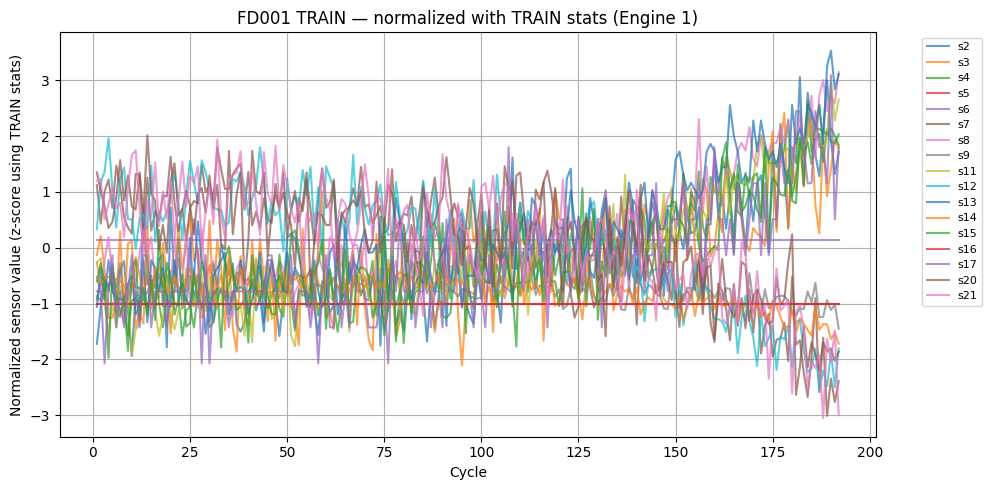

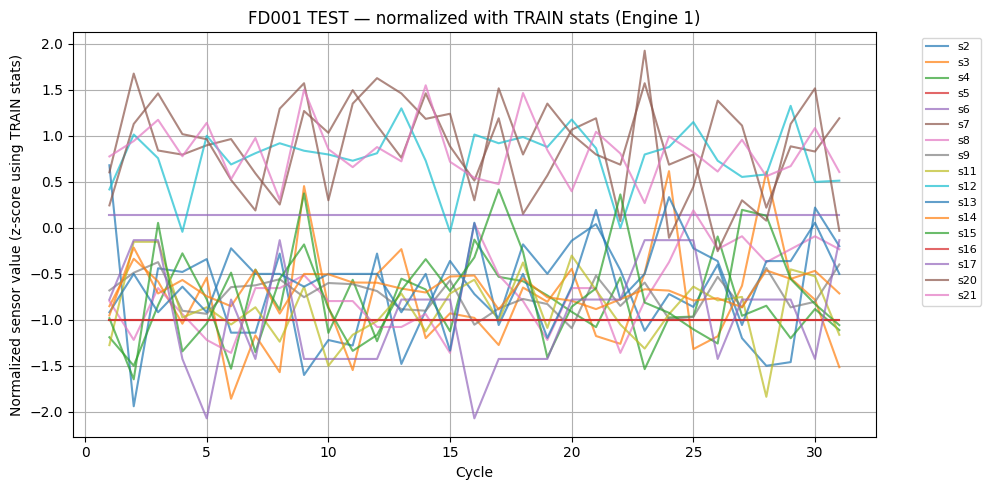

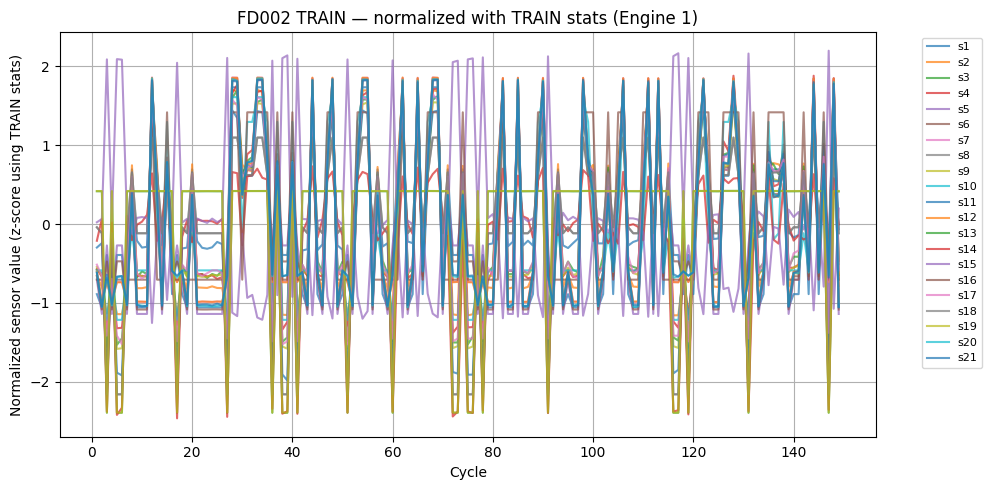

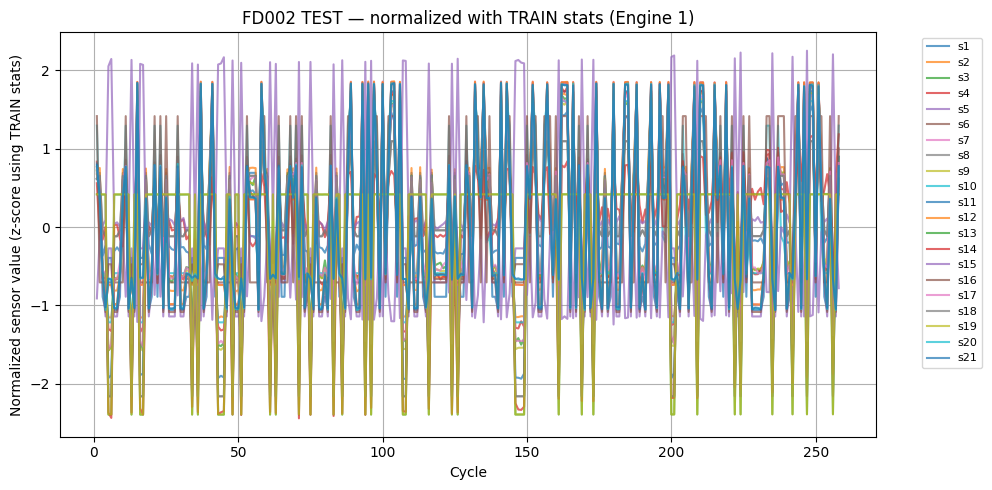

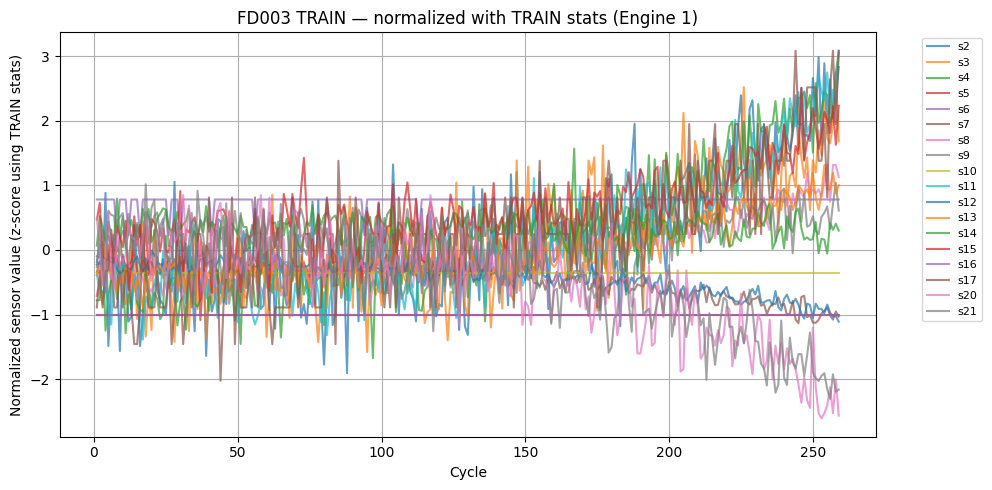

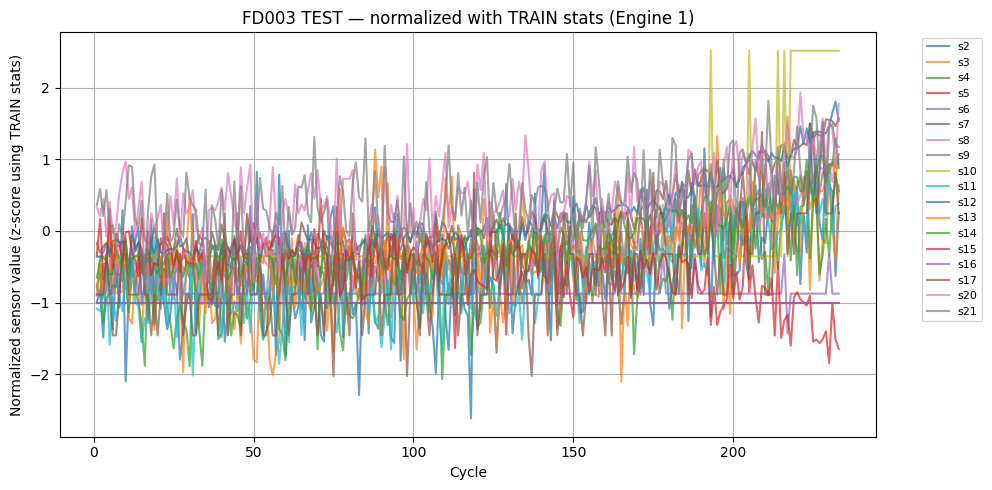

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def get_train_stats(df_train):
    sensor_cols = [c for c in df_train.columns if c.startswith("s")]
    mu = df_train[sensor_cols].mean()
    sigma = df_train[sensor_cols].std().replace(0, np.nan)
    return sensor_cols, mu, sigma

def plot_normalized_sensors_with_train_stats(df, engine_id, sensor_cols, mu, sigma, title=""):
    df_e = df[df["unit_nr"] == engine_id].sort_values("cycle")

    plt.figure(figsize=(10, 5))
    for s in sensor_cols:
        if np.isnan(sigma[s]):
            continue
        x_norm = (df_e[s] - mu[s]) / sigma[s]
        plt.plot(df_e["cycle"], x_norm, alpha=0.7, label=s)

    plt.xlabel("Cycle")
    plt.ylabel("Normalized sensor value (z-score using TRAIN stats)")
    plt.title(title)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
    plt.tight_layout()
    plt.show()

engine_id = 1

# =========================
# FD001
# =========================
s_cols_1, mu1, sig1 = get_train_stats(df_train)
plot_normalized_sensors_with_train_stats(df_train, engine_id, s_cols_1, mu1, sig1,
    "FD001 TRAIN — normalized with TRAIN stats (Engine 1)")
plot_normalized_sensors_with_train_stats(df_test, engine_id, s_cols_1, mu1, sig1,
    "FD001 TEST — normalized with TRAIN stats (Engine 1)")

# =========================
# FD002
# =========================
s_cols_2, mu2, sig2 = get_train_stats(df_train2)
plot_normalized_sensors_with_train_stats(df_train2, engine_id, s_cols_2, mu2, sig2,
    "FD002 TRAIN — normalized with TRAIN stats (Engine 1)")
plot_normalized_sensors_with_train_stats(df_test2, engine_id, s_cols_2, mu2, sig2,
    "FD002 TEST — normalized with TRAIN stats (Engine 1)")

# =========================
# FD003
# =========================
s_cols_3, mu3, sig3 = get_train_stats(df_train3)
plot_normalized_sensors_with_train_stats(df_train3, engine_id, s_cols_3, mu3, sig3,
    "FD003 TRAIN — normalized with TRAIN stats (Engine 1)")
plot_normalized_sensors_with_train_stats(df_test3, engine_id, s_cols_3, mu3, sig3,
    "FD003 TEST — normalized with TRAIN stats (Engine 1)")


## Interpretation of Normalized Sensor Trajectories Across Scenarios

The three plots illustrate the normalized temporal evolution of the 21 sensor measurements for a representative engine in each C-MAPSS scenario (FD001, FD002, and FD003). Although the same sensors are visualized across all scenarios, their behaviors differ substantially, highlighting fundamental differences in degradation dynamics and data complexity.



### FD001 — Clear and Progressive Degradation Patterns

**Observed behavior**

In FD001, most sensor trajectories exhibit:
- a relatively smooth temporal evolution,
- consistent monotonic trends (either increasing or decreasing),
- limited noise and few abrupt variations.

As the engine approaches failure, several sensors progressively diverge from their initial operating levels, indicating a clear and gradual degradation process.

**Interpretation**

FD001 corresponds to a single operating condition and a single fault mode. Sensor variations are therefore primarily driven by degradation rather than by changes in operating regimes.

**Implications for modeling**

- Minimal preprocessing is required.
- Simple regression models can already achieve strong performance.
- A limited subset of informative sensors captures most of the degradation signal.



### FD002 — Highly Noisy and Regime-Driven Sensor Behavior

**Observed behavior**

In FD002, sensor trajectories show:
- strong oscillations and abrupt transitions,
- frequent changes in signal amplitude,
- weak, non-monotonic, or masked degradation trends.

Even after per-engine normalization, the sensor signals remain dominated by variability rather than by smooth degradation patterns.

**Interpretation**

FD002 involves multiple operating conditions and a single fault mode. Many sensors are more sensitive to regime changes than to degradation itself, which obscures the degradation signal.

**Implications for modeling**

- Noise reduction techniques (e.g., EWMA smoothing) are required.
- Robust feature selection is necessary to suppress regime-dependent sensors.
- Models must generalize across changing operating conditions, significantly increasing prediction difficulty.



### FD003 — Structured Degradation with Heterogeneous Patterns

**Observed behavior**

In FD003, sensor trajectories display:
- global degradation trends similar to FD001,
- higher noise levels than FD001,
- heterogeneous behaviors across sensors.

Some sensors are strongly correlated with degradation, while others respond differently depending on the underlying failure mode.

**Interpretation**

FD003 corresponds to a single operating condition and multiple fault modes. Distinct failure mechanisms generate diverse degradation signatures across engines.

**Implications for modeling**

- Sensor redundancy must be addressed carefully.
- Feature selection should focus on sensors that generalize across multiple fault modes.
- Models must capture diverse degradation trajectories rather than relying on a single dominant trend.



## Comparative Analysis and Methodological Consequences

The comparison highlights that sensor relevance and degradation observability are strongly scenario-dependent.

| Scenario | Main difficulty | Dominant effect | Recommended approach |
|----------|----------------|-----------------|----------------------|
| FD001    | Low            | Pure degradation | Simple models, minimal preprocessing |
| FD002    | High           | Operating-condition variability | EWMA smoothing, robust feature selection |
| FD003    | Medium         | Multiple fault modes | Feature selection, regularized models |



## Conclusion

These observations justify the adoption of scenario-specific preprocessing strategies. While FD001 enables relatively straightforward modeling, FD002 and FD003 require additional noise mitigation and careful feature engineering to extract reliable degradation information and improve Remaining Useful Life (RUL) prediction performance.


In [7]:
import matplotlib.pyplot as plt

def plot_rul_distribution(df_train, scenario_name):
    df_rul_train = df_train.copy()

    df_rul_train["RUL"] = (
        df_rul_train.groupby("unit_nr")["cycle"].transform("max")
        - df_rul_train["cycle"]
    )

    plt.figure(figsize=(7, 4))
    plt.hist(df_rul_train["RUL"], bins=30)
    plt.xlabel("Remaining Useful Life (cycles)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of RUL in Training Set ({scenario_name})")
    plt.grid(True, alpha=0.3)
    plt.show()

    return df_rul_train


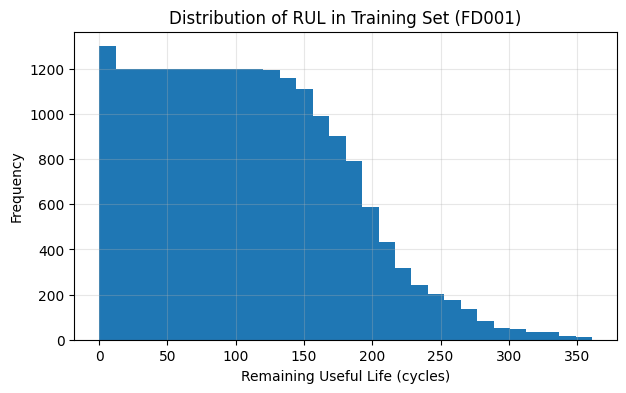

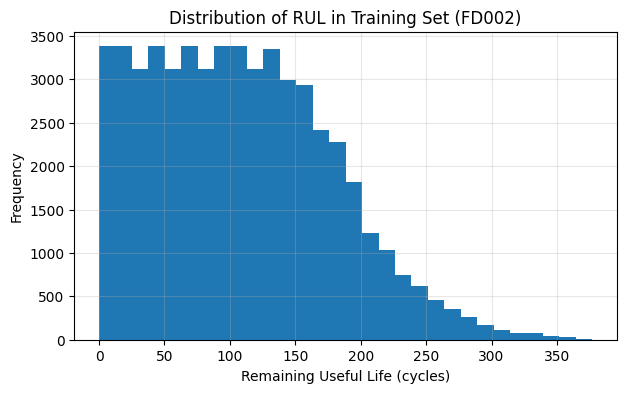

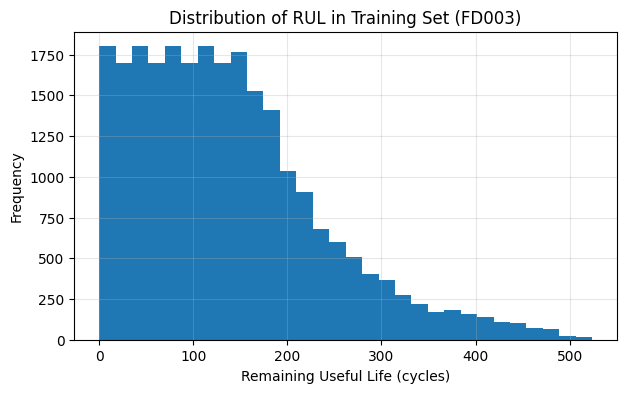

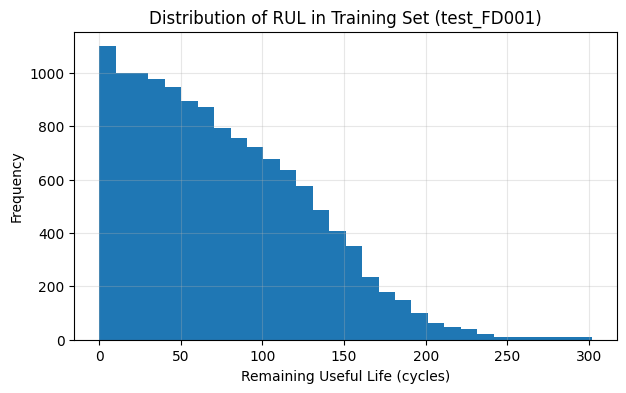

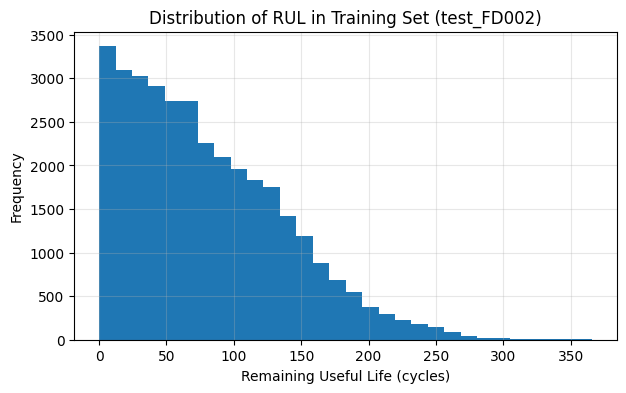

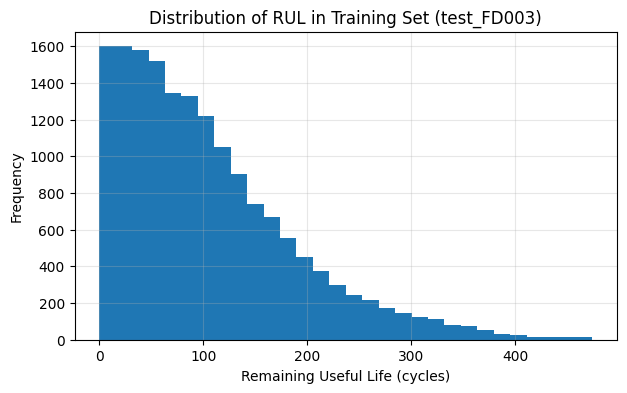

In [8]:
df_rul_train_001 = plot_rul_distribution(df_train,  "FD001")
df_rul_train_002 = plot_rul_distribution(df_train2, "FD002")
df_rul_train_003 = plot_rul_distribution(df_train3, "FD003")

df_rul_train_001 = plot_rul_distribution(df_test,  "test_FD001")
df_rul_train_002 = plot_rul_distribution(df_test2, "test_FD002")
df_rul_train_003 = plot_rul_distribution(df_test3, "test_FD003")


In [9]:
[k for k in globals().keys() if "fd" in k.lower()]
['df_train', 'df_test', 'df_train2', 'df_test2', 'df_train3', 'df_test3']



['df_train', 'df_test', 'df_train2', 'df_test2', 'df_train3', 'df_test3']

## Analysis of RUL distributions across C-MAPSS scenarios

The following figures present the distribution of the Remaining Useful Life (RUL) values in the training set for the three considered C-MAPSS scenarios: FD001, FD002, and FD003.

Each histogram represents the frequency of RUL values (in cycles) observed across all engines and all operating cycles in the corresponding dataset.

### FD001 — Single operating condition, single fault mode

The RUL distribution for FD001 exhibits a relatively smooth and well-shaped profile, with a high concentration of samples at low and intermediate RUL values and a gradual decay for higher RULs.  
This behavior is expected given the simplicity of the scenario: all engines operate under a single regime and degrade according to a single fault mode.

As a consequence:
- degradation patterns are consistent across engines,
- sensor trajectories are more homogeneous,
- and the RUL target is easier to model using standard regression approaches.

This scenario typically serves as a baseline for predictive maintenance models.

### FD002 — Multiple operating conditions, single fault mode

In FD002, the RUL distribution is noticeably broader and more irregular than in FD001.  
The presence of multiple operating conditions increases the variability of degradation trajectories and induces a less concentrated RUL distribution.

Key observations include:
- a higher dispersion of RUL values,
- a more uniform coverage of intermediate RUL ranges,
- and a longer tail toward high RUL values.

This reflects the fact that engines may experience different stress regimes before reaching similar degradation levels.  
As a result, the RUL prediction task becomes more sensitive to noise and operational variability, requiring preprocessing techniques that are robust to regime changes.

### FD003 — Single operating condition, multiple fault modes

The FD003 scenario presents the widest RUL distribution among the three datasets, with significantly larger maximum RUL values.  
Although operating conditions remain constant, the presence of multiple fault modes leads to heterogeneous degradation behaviors across engines.

This results in:
- strong inter-engine variability,
- overlapping degradation patterns,
- and a long-tailed RUL distribution.

In this setting, not all engines degrade in the same way, even under identical operating conditions, which makes global modeling more challenging.

### Implications for data preprocessing and modeling

Across the three scenarios, the RUL distributions highlight increasing levels of complexity from FD001 to FD003.  
Rather than performing entirely separate analyses for each scenario, these observations motivate a unified preprocessing pipeline that:

- adapts noise reduction and smoothing strategies to varying levels of variability,
- avoids overly aggressive feature elimination based solely on global statistics,
- and relies on model-based feature relevance rather than fixed heuristic rules.

In particular, these distributions suggest that preprocessing steps such as RUL clipping, temporal smoothing, and robust feature selection should be designed to remain effective across heterogeneous degradation patterns.


Réduction du bruit

implémentation des algorithme de prédiction et évaluation des modèles de prédiction

### Noise characteristics across scenarios

While per-engine z-score normalization allows sensor trajectories to be visualized on a common scale, it does not reduce measurement noise or operating-condition-induced variability.

The visual differences observed across FD001, FD002, and FD003 therefore reflect genuine differences in signal structure rather than scaling effects.

In FD001, the relatively smooth and monotonic sensor trajectories suggest that noise levels are limited and that minimal smoothing is sufficient.

In FD002, strong oscillations and abrupt variations indicate that a significant portion of the signal variability is driven by operating condition changes rather than degradation. In this case, explicit noise reduction is required to improve signal-to-noise ratio before feature selection and modeling.

In FD003, degradation trends remain visible but are highly heterogeneous across engines due to multiple fault modes. Noise reduction must therefore be applied carefully to avoid masking fault-specific signatures.

These observations motivate the use of a unified noise reduction mechanism with scenario-adaptive strength, applied after normalization but prior to feature selection and model training.



In [10]:
import pandas as pd

# ============================================================
# EWMA denoising (per engine) for df_train / df_train2 / df_train3
# ============================================================

def ewma_per_unit(df: pd.DataFrame, sensor_cols, span: int) -> pd.DataFrame:
    """
    Apply EWMA smoothing per engine (unit_nr) and per sensor column.
    - Sorts by (unit_nr, cycle)
    - No leakage across engines
    - Returns a denoised copy
    """
    df_dn = df.sort_values(["unit_nr", "cycle"]).copy()
    g = df_dn.groupby("unit_nr", sort=False)

    for c in sensor_cols:
        if c in df_dn.columns:
            df_dn[c] = g[c].transform(lambda s: s.ewm(span=span, adjust=False).mean())

    return df_dn


# -------------------------
# Sensors to denoise
# -------------------------
all_sensors = [f"s{i}" for i in range(1, 22)]  # or your reduced list

# -------------------------
# Keep raw copies (optional but recommended)
# -------------------------
df_train_raw  = df_train.copy()
df_test_raw   = df_test.copy()
df_train2_raw = df_train2.copy()
df_test2_raw  = df_test2.copy()
df_train3_raw = df_train3.copy()
df_test3_raw  = df_test3.copy()

# -------------------------
# Apply denoising (scenario-adaptive spans)
# -------------------------
df_train  = ewma_per_unit(df_train,  all_sensors, span=10)  # FD001
df_test   = ewma_per_unit(df_test,   all_sensors, span=10)

df_train2 = ewma_per_unit(df_train2, all_sensors, span=18)  # FD002
df_test2  = ewma_per_unit(df_test2,  all_sensors, span=18)

df_train3 = ewma_per_unit(df_train3, all_sensors, span=14)  # FD003
df_test3  = ewma_per_unit(df_test3,  all_sensors, span=14)

# -------------------------
# Quick checks
# -------------------------
print("✅ Denoising done:")
print("FD001:", df_train.shape, df_test.shape)
print("FD002:", df_train2.shape, df_test2.shape)
print("FD003:", df_train3.shape, df_test3.shape)

print("\nHead (FD001):")
print(df_train[["unit_nr", "cycle"]].head())


✅ Denoising done:
FD001: (20631, 27) (13096, 27)
FD002: (53759, 27) (33991, 27)
FD003: (24720, 27) (16596, 27)

Head (FD001):
   unit_nr  cycle
0        1      1
1        1      2
2        1      3
3        1      4
4        1      5


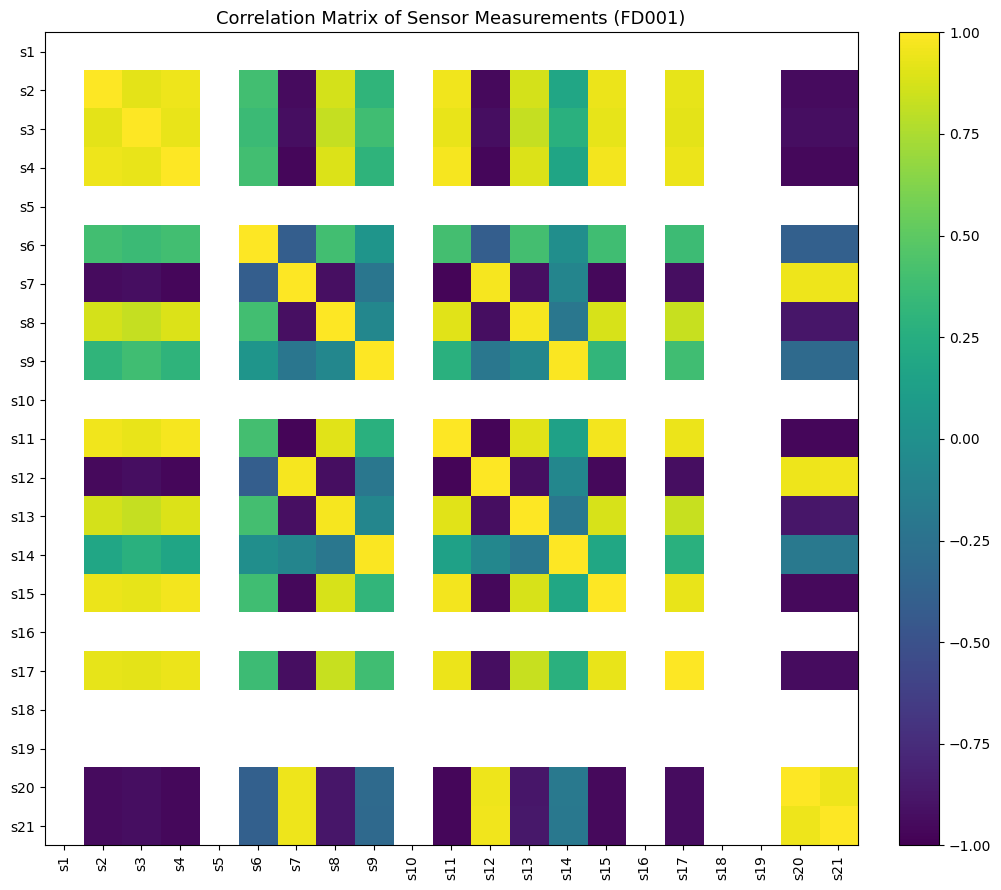

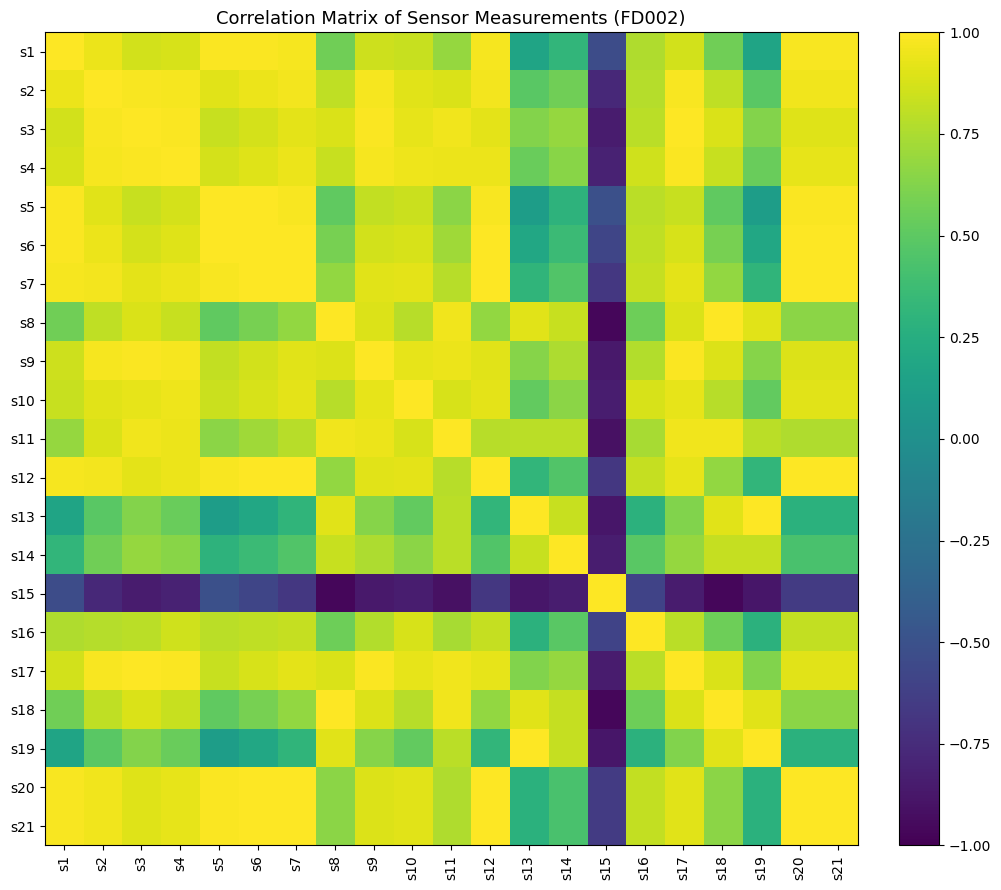

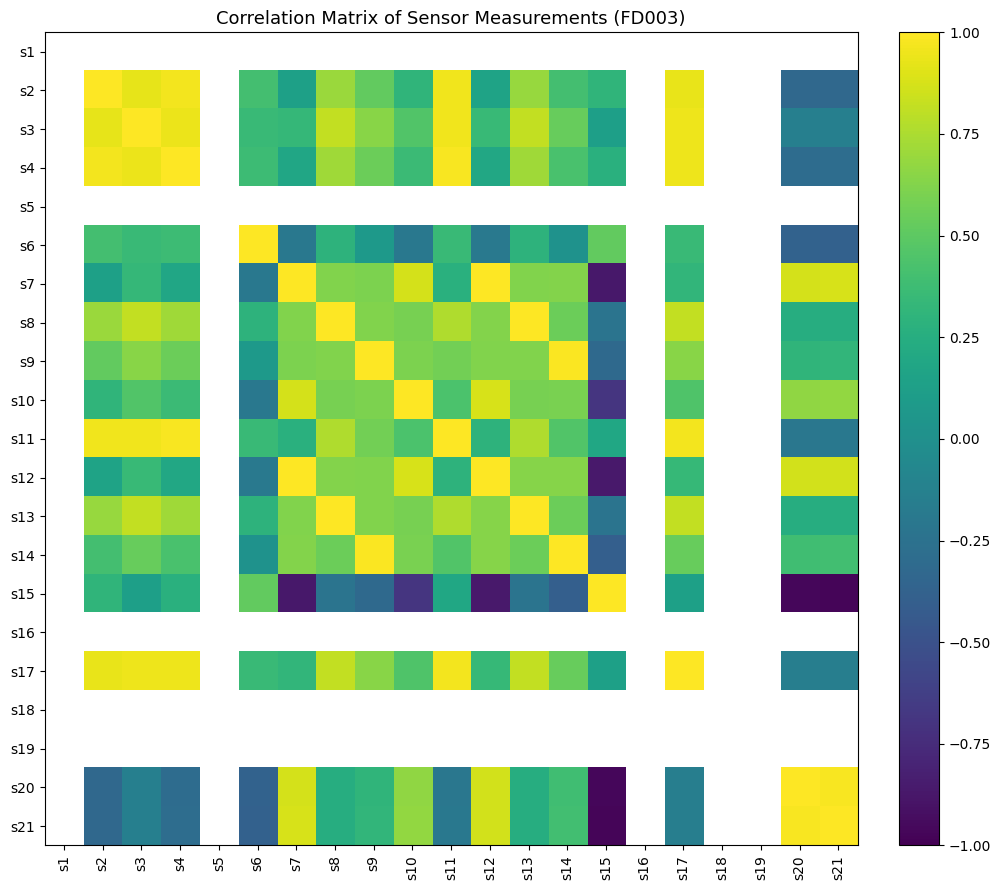

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_sensor_correlation(df, scenario_name):
    # sélection automatique des capteurs
    sensor_cols = [c for c in df.columns if c.startswith("s")]

    # matrice de corrélation
    corr = df[sensor_cols].corr()

    # plot
    plt.figure(figsize=(11, 9))
    im = plt.imshow(corr, cmap="viridis", vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.title(f"Correlation Matrix of Sensor Measurements ({scenario_name})", fontsize=13)
    plt.xticks(range(len(sensor_cols)), sensor_cols, rotation=90)
    plt.yticks(range(len(sensor_cols)), sensor_cols)

    plt.tight_layout()
    plt.show()

plot_sensor_correlation(df_train,  "FD001")
plot_sensor_correlation(df_train2, "FD002")
plot_sensor_correlation(df_train3, "FD003")



# How we move from interpretation to actual decisions

So far, the correlation matrices helped us understand the structure of the data, but they do not by themselves tell us which variables to remove. To make decisions, we need to connect the sensors directly to the degradation process and the RUL prediction task.

## What we measure next

The focus must shift from relationships between sensors to relationships between each sensor and degradation. For every sensor and for each scenario, we need to examine how the signal evolves with cycle count and with Remaining Useful Life. The key question is not whether two sensors look similar overall, but whether they provide information at the same moments in the engine lifetime. Sensors can be correlated and still differ in when and how they respond to degradation.

## The real criterion for removing a sensor

A sensor should never be removed solely because it is correlated with another one. Removal is justified only if the sensor’s temporal evolution is almost identical to another sensor, if both carry the same information with respect to RUL, and if the sensor never becomes informative at any critical stage of degradation. In other words, a sensor can be removed only if it adds no new information at any point in time.

## Scenario-specific reasoning

In FD001, correlation reflects a clean and dominant degradation process. Sensors can be grouped using correlation, but reduction must remain conservative. Within each group, sensors with very weak or redundant sensitivity to RUL can be removed, while keeping multiple sensors to preserve robustness over the engine lifetime.

In FD002, correlation is largely driven by operating conditions rather than degradation. High correlation does not imply redundancy. Sensor removal should focus on eliminating variables whose behavior is dominated by regime changes and whose relationship with RUL is unstable across operating conditions. Only limited, targeted reduction is appropriate.

In FD003, the scenario plays a validation role. Sensors that appear removable in FD001 or FD002 must still preserve performance in FD003. If removing a sensor significantly degrades performance in FD003, that sensor should be considered essential.

## What we do concretely next

The next step is to analyze sensor trajectories with respect to cycle and RUL, measure their temporal sensitivity across the lifetime, and compare sensors within correlated groups. A sensor is removed only when another clearly dominates it in terms of degradation information over time. This transforms correlation analysis from a descriptive tool into a decision-making process.


In [13]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor

# -------------------------
# Helpers (rapides)
# -------------------------
def sensor_cols_strict(df):
    # s1, s2, ..., s21 uniquement
    return sorted([c for c in df.columns if c.startswith("s") and c[1:].isdigit()])

def drop_constant(df, sensors, var_eps=1e-12):
    v = df[sensors].var()
    keep = [c for c in sensors if v[c] > var_eps]
    drop = [c for c in sensors if c not in keep]
    return keep, drop

def corr_prune_train(df, sensors, thr=0.95):
    corr = df[sensors].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    to_drop = set()
    while True:
        m = upper.max().max()
        if pd.isna(m) or m < thr:
            break
        i, j = np.where(upper.values == m)
        a = upper.index[int(i[0])]
        b = upper.columns[int(j[0])]
        drop_col = a if corr[a].mean() >= corr[b].mean() else b
        to_drop.add(drop_col)
        upper.loc[drop_col, :] = np.nan
        upper.loc[:, drop_col] = np.nan

    keep = [c for c in sensors if c not in to_drop]
    return keep, sorted(to_drop)

def select_fast_corr(train_df, k=12, rul_col="RUL", thr=0.95):
    sensors = sensor_cols_strict(train_df)
    sensors, drop_const = drop_constant(train_df, sensors)
    sensors, drop_corr = corr_prune_train(train_df, sensors, thr)

    y = train_df[rul_col].astype(float)
    scores = {
        c: abs(train_df[c].astype(float).corr(y))
        for c in sensors
    }
    scores = {c: (0.0 if pd.isna(v) else float(v)) for c, v in scores.items()}

    ranked = sorted(sensors, key=lambda c: scores[c], reverse=True)
    keep = ranked[:k]
    return keep, {"drop_const": drop_const, "drop_corr": drop_corr, "scores": scores}

def select_fast_trees(train_df, k=12, rul_col="RUL", seed=42):
    sensors = sensor_cols_strict(train_df)
    sensors, drop_const = drop_constant(train_df, sensors)

    X = train_df[sensors].astype(float)
    y = train_df[rul_col].astype(float).values

    model = ExtraTreesRegressor(
        n_estimators=300,
        random_state=seed,
        n_jobs=-1
    )
    model.fit(X, y)

    scores = {c: float(v) for c, v in zip(sensors, model.feature_importances_)}
    ranked = sorted(sensors, key=lambda c: scores[c], reverse=True)
    keep = ranked[:k]
    return keep, {"drop_const": drop_const, "tree_importance": scores}


In [17]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor

def sensor_cols_strict(df):
    return sorted([c for c in df.columns if c.startswith("s") and c[1:].isdigit()])

def drop_constant(df, sensors, var_eps=1e-12):
    v = df[sensors].var()
    return [c for c in sensors if v[c] > var_eps]

def corr_prune_train(df, sensors, thr=0.95):
    corr = df[sensors].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = set()
    while True:
        m = upper.max().max()
        if pd.isna(m) or m < thr:
            break
        i, j = np.where(upper.values == m)
        a = upper.index[int(i[0])]
        b = upper.columns[int(j[0])]
        drop_col = a if corr[a].mean() >= corr[b].mean() else b
        to_drop.add(drop_col)
        upper.loc[drop_col, :] = np.nan
        upper.loc[:, drop_col] = np.nan
    return [c for c in sensors if c not in to_drop]

def select_fd001_fast(df_train, k=12, thr=0.95):
    sensors = drop_constant(df_train, sensor_cols_strict(df_train))
    sensors = corr_prune_train(df_train, sensors, thr=thr)

    # vectorisé (plus rapide que boucle)
    scores = df_train[sensors].corrwith(df_train["RUL"].astype(float)).abs().fillna(0.0)
    keep = scores.sort_values(ascending=False).index[:k].tolist()
    return keep

def select_trees_fast(df_train, k=12, seed=42, n_estimators=200, max_rows=None):
    sensors = drop_constant(df_train, sensor_cols_strict(df_train))

    df_use = df_train
    if max_rows is not None and len(df_use) > max_rows:
        df_use = df_use.sample(n=max_rows, random_state=seed)

    X = df_use[sensors].astype(np.float32).values
    y = df_use["RUL"].astype(np.float32).values

    model = ExtraTreesRegressor(
        n_estimators=n_estimators,
        random_state=seed,
        n_jobs=-1
    )
    model.fit(X, y)

    imp = model.feature_importances_
    idx = np.argsort(imp)[::-1][:k]
    keep = [sensors[i] for i in idx]
    return keep

# --- outputs compatibles avec ton GBR ---
keep_001 = select_fd001_fast(df_train,  k=12, thr=0.95)
keep_002 = select_trees_fast(df_train2, k=12, seed=42, n_estimators=200, max_rows=50000)
keep_003 = select_trees_fast(df_train3, k=14, seed=42, n_estimators=200, max_rows=50000)

print("FD001 keep:", keep_001)
print("FD002 keep:", keep_002)
print("FD003 keep:", keep_003)


FD001 keep: ['s17', 's3', 's2', 's7', 's8', 's14', 's6']
FD002 keep: ['s15', 's11', 's14', 's16', 's10', 's4', 's1', 's2', 's13', 's18', 's19', 's8']
FD003 keep: ['s3', 's11', 's4', 's17', 's6', 's2', 's14', 's9', 's8', 's13', 's7', 's12', 's15', 's21']


In [ ]:
 # %% [code]
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def add_rul(df):
    df2 = df.sort_values(["unit_nr", "cycle"]).copy()
    df2["RUL"] = df2.groupby("unit_nr")["cycle"].transform("max") - df2["cycle"]
    return df2


def get_sensor_cols(df):
    return [c for c in df.columns if c.startswith("s")]


def gbr_fit_predict(df_train, keep_list=None, seed=42):
    df = add_rul(df_train)

    X_cols = get_sensor_cols(df)
    if keep_list is not None:
        X_cols = [c for c in X_cols if c in set(keep_list)]

    X = df[X_cols].values
    y = df["RUL"].values
    groups = df["unit_nr"].values

    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    tr_idx, va_idx = next(splitter.split(X, y, groups=groups))

    X_tr, X_va = X[tr_idx], X[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    model = GradientBoostingRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.9,
        random_state=seed
    )
    model.fit(X_tr, y_tr)
    pred = model.predict(X_va)

    mae = mean_absolute_error(y_va, pred)
    rmse = float(np.sqrt(mean_squared_error(y_va, pred)))
    r2 = r2_score(y_va, pred)

    return y_va, pred, mae, rmse, r2, len(X_cols)


def plot_true_vs_pred(y_true, y_pred, mae, rmse, r2, n_features, title):
    plt.figure(figsize=(7, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)

    m = max(float(np.max(y_true)), float(np.max(y_pred)))
    plt.plot([0, m], [0, m], "--")

    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(title)

    plt.text(
        0.05, 0.95,
        f"MAE = {mae:.2f}\nRMSE = {rmse:.2f}\nR² = {r2:.3f}\nFeatures = {n_features}",
        transform=plt.gca().transAxes,
        va="top",
        fontsize=11
    )

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# =========================
# 3 PLOTS (one per scenario)
# =========================

# FD001
y_true, y_pred, mae, rmse, r2, nf = gbr_fit_predict(df_train, keep_list=keep_001)
plot_true_vs_pred(y_true, y_pred, mae, rmse, r2, nf, "Gradient Boosting – True vs Predicted RUL (FD001)")

# FD002
y_true, y_pred, mae, rmse, r2, nf = gbr_fit_predict(df_train2, keep_list=keep_002)
plot_true_vs_pred(y_true, y_pred, mae, rmse, r2, nf, "Gradient Boosting – True vs Predicted RUL (FD002)")

# FD003
y_true, y_pred, mae, rmse, r2, nf = gbr_fit_predict(df_train3, keep_list=keep_003)
plot_true_vs_pred(y_true, y_pred, mae, rmse, r2, nf, "Gradient Boosting – True vs Predicted RUL (FD003)")




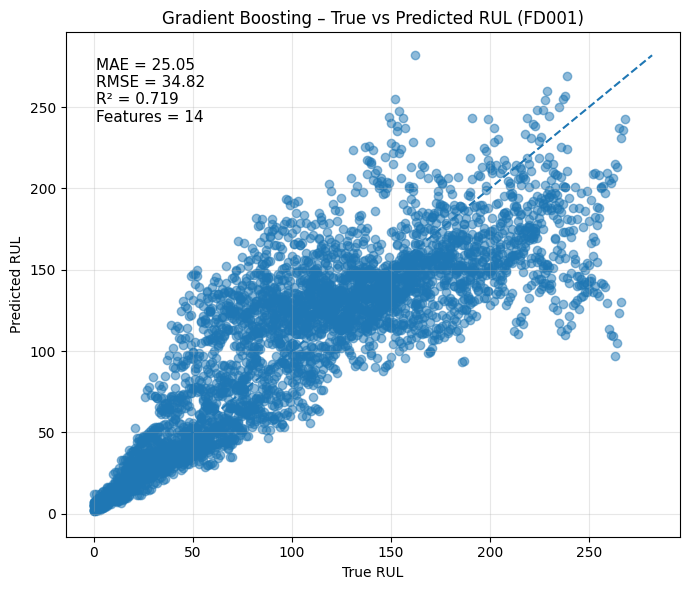

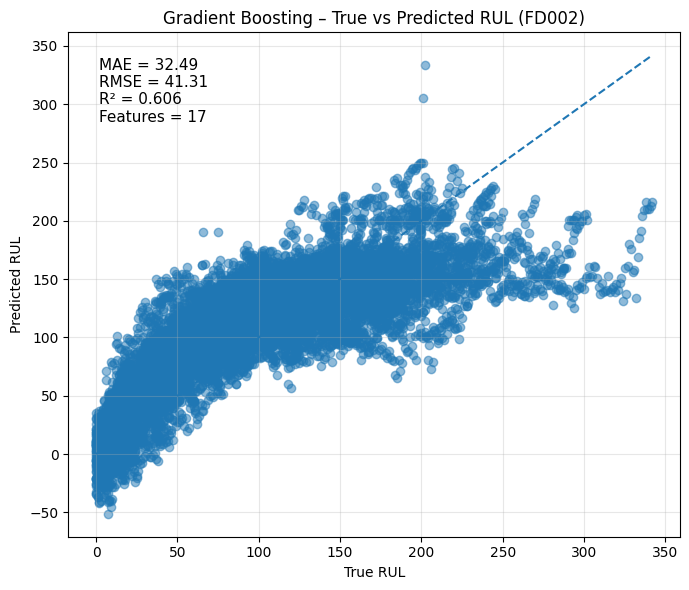

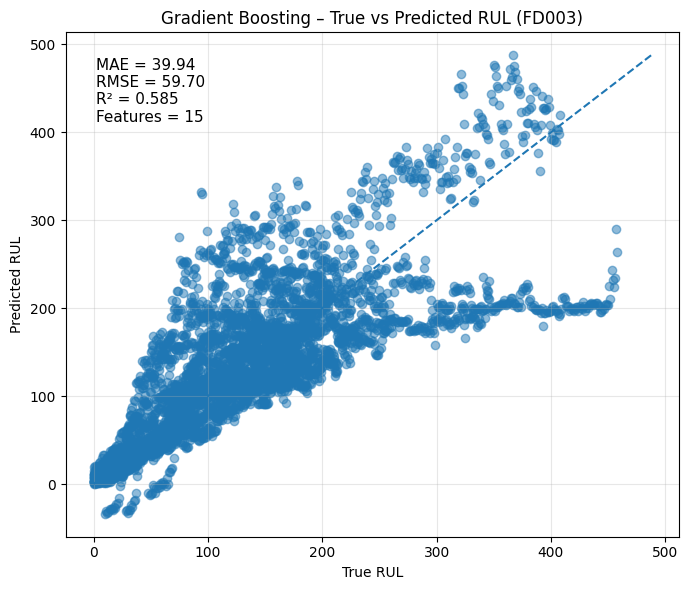


=== Gradient Boosting results ===
{'scenario': 'FD001', 'n_features': 14, 'MAE': 25.049228171528412, 'RMSE': 34.81728489667369, 'R2': 0.7187483180706606}
{'scenario': 'FD002', 'n_features': 17, 'MAE': 32.49156097568787, 'RMSE': 41.3101088644413, 'R2': 0.6058033596471498}
{'scenario': 'FD003', 'n_features': 15, 'MAE': 39.94424308984765, 'RMSE': 59.695400947988176, 'R2': 0.5854959415358207}


In [ ]:
res_001 = eval_gradient_boosting(df_train,  "FD001", keep_list=keep_001)
res_002 = eval_gradient_boosting(df_train2, "FD002", keep_list=keep_002)
res_003 = eval_gradient_boosting(df_train3, "FD003", keep_list=keep_003)

print("\n=== Gradient Boosting results ===")
print(res_001)
print(res_002)
print(res_003)


In [33]:
te_last = df_test.groupby("unit_nr")["cycle"].idxmax()
units = df_test.loc[te_last, "unit_nr"].sort_values().values

print("First 10 unit_nr:", units[:10])
print("First 10 rul1:", np.asarray(rul).reshape(-1)[:10])
print("Nb units:", len(units), "| Nb rul1:", len(rul))


First 10 unit_nr: [ 1  2  3  4  5  6  7  8  9 10]
First 10 rul1: [112  98  69  82  91  93  91  95 111  96]
Nb units: 100 | Nb rul1: 100


Starting FD001...


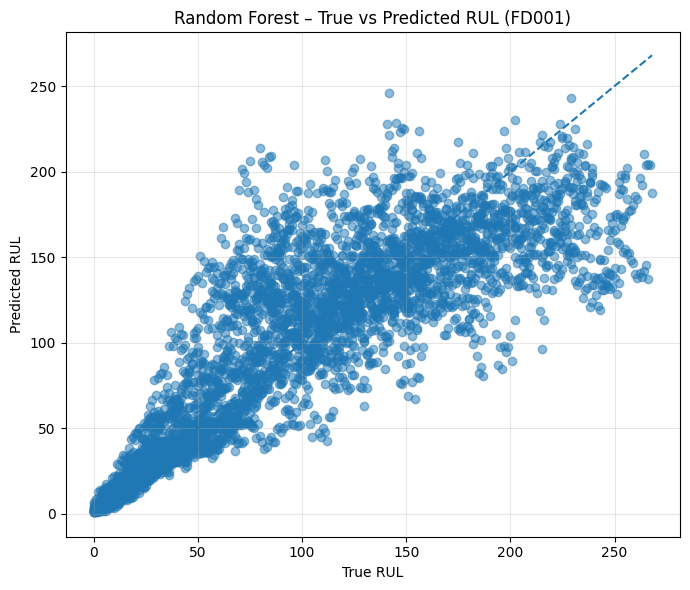

Done FD001: {'scenario': 'FD001', 'n_features': 7, 'MAE': 25.240306672818832, 'RMSE': 35.91027049901661, 'R2': 0.700813027604235}

Starting FD002...


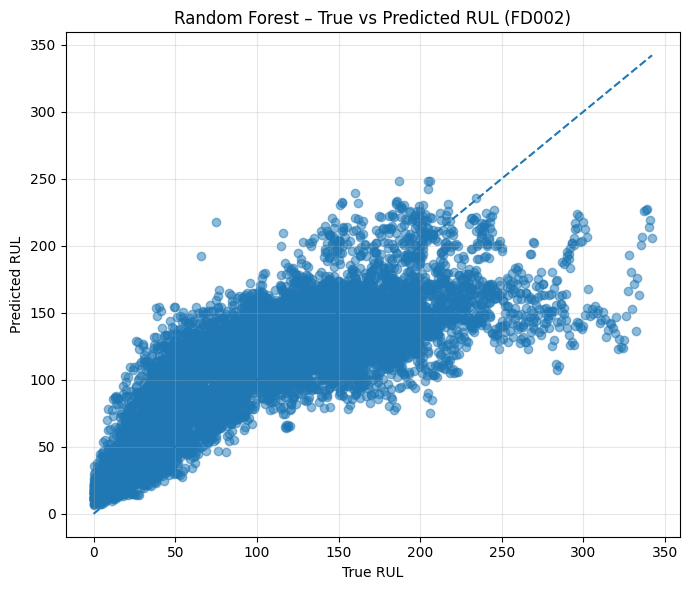

Done FD002: {'scenario': 'FD002', 'n_features': 12, 'MAE': 31.506100384205816, 'RMSE': 40.65420308326524, 'R2': 0.6182217839947444}

Starting FD003...


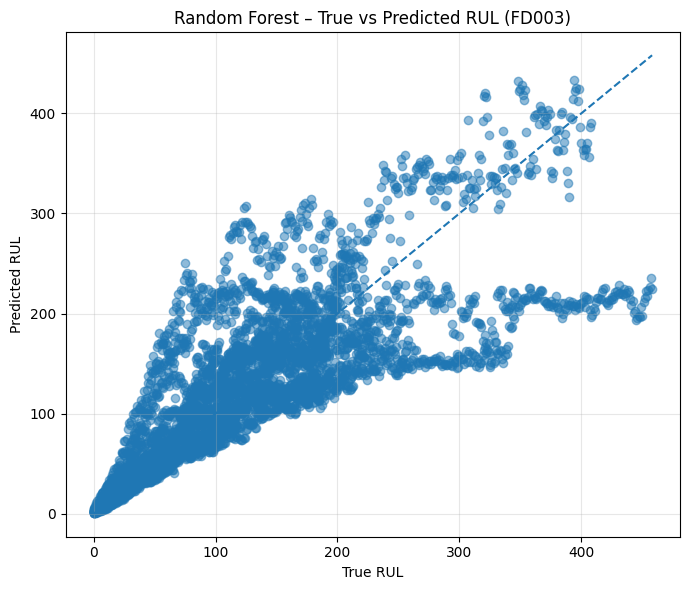

Done FD003: {'scenario': 'FD003', 'n_features': 14, 'MAE': 38.06345773173006, 'RMSE': 57.743760251442, 'R2': 0.6121559232032969}

=== Random Forest results ===
{'scenario': 'FD001', 'n_features': 7, 'MAE': 25.240306672818832, 'RMSE': 35.91027049901661, 'R2': 0.700813027604235}
{'scenario': 'FD002', 'n_features': 12, 'MAE': 31.506100384205816, 'RMSE': 40.65420308326524, 'R2': 0.6182217839947444}
{'scenario': 'FD003', 'n_features': 14, 'MAE': 38.06345773173006, 'RMSE': 57.743760251442, 'R2': 0.6121559232032969}


In [23]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def add_rul(df):
    df2 = df.sort_values(["unit_nr","cycle"]).copy()
    df2["RUL"] = df2.groupby("unit_nr")["cycle"].transform("max") - df2["cycle"]
    return df2


def get_sensor_cols(df):
    return [c for c in df.columns if c.startswith("s")]


def eval_rf_scenario(df_train_scenario, scenario_name, keep_list=None, seed=42, plot=True):
    df = add_rul(df_train_scenario)

    X_cols = get_sensor_cols(df)
    if keep_list is not None:
        X_cols = [c for c in X_cols if c in set(keep_list)]

    X = df[X_cols].values
    y = df["RUL"].values
    groups = df["unit_nr"].values

    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    tr_idx, va_idx = next(splitter.split(X, y, groups=groups))

    X_tr, X_va = X[tr_idx], X[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    # Faster RF (FD002/FD003 won't "freeze" forever)
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_leaf=5,
        max_features="sqrt",
        n_jobs=-1,
        random_state=seed
    )
    model.fit(X_tr, y_tr)
    pred = model.predict(X_va)

    mae  = mean_absolute_error(y_va, pred)
    rmse = float(np.sqrt(mean_squared_error(y_va, pred)))
    r2   = r2_score(y_va, pred)

    if plot:
        plt.figure(figsize=(7, 6))
        plt.scatter(y_va, pred, alpha=0.5)
        m = max(float(np.max(y_va)), float(np.max(pred)))
        plt.plot([0, m], [0, m], "--")
        plt.xlabel("True RUL")
        plt.ylabel("Predicted RUL")
        plt.title(f"Random Forest – True vs Predicted RUL ({scenario_name})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return {
        "scenario": scenario_name,
        "n_features": len(X_cols),
        "MAE": float(mae),
        "RMSE": float(rmse),
        "R2": float(r2)
    }


# ---- Run sequentially with live feedback ----
print("Starting FD001...")
rf_001 = eval_rf_scenario(df_train,  "FD001", keep_list=keep_001, plot=True)
print("Done FD001:", rf_001)

print("\nStarting FD002...")
rf_002 = eval_rf_scenario(df_train2, "FD002", keep_list=keep_002, plot=True)
print("Done FD002:", rf_002)

print("\nStarting FD003...")
rf_003 = eval_rf_scenario(df_train3, "FD003", keep_list=keep_003, plot=True)
print("Done FD003:", rf_003)

print("\n=== Random Forest results ===")
print(rf_001)
print(rf_002)
print(rf_003)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


def add_rul(df):
    df2 = df.sort_values(["unit_nr","cycle"]).copy()
    df2["RUL"] = df2.groupby("unit_nr")["cycle"].transform("max") - df2["cycle"]
    return df2


def get_sensor_cols(df, keep_list):
    return [c for c in df.columns if c.startswith("s") and c in set(keep_list)]


def make_sequences(df, sensor_cols, window=30):
    X, y = [], []
    for _, g in df.groupby("unit_nr"):
        g = g.sort_values("cycle")
        vals = g[sensor_cols].values
        rul  = g["RUL"].values
        if len(g) < window:
            continue
        for i in range(len(g) - window + 1):
            X.append(vals[i:i+window])
            y.append(rul[i+window-1])
    return np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.float32)


def standardize_sequences(X_tr, X_va):
    # compute mean/std on TRAIN ONLY over (samples*time)
    mu = X_tr.reshape(-1, X_tr.shape[-1]).mean(axis=0)
    sd = X_tr.reshape(-1, X_tr.shape[-1]).std(axis=0) + 1e-8
    X_tr_z = (X_tr - mu) / sd
    X_va_z = (X_va - mu) / sd
    return X_tr_z, X_va_z


def eval_lstm_scenario(df_train_scenario, scenario_name, keep_list,
                      window=30, seed=42, epochs=40, batch_size=256, plot=True):

    df = add_rul(df_train_scenario)
    sensor_cols = get_sensor_cols(df, keep_list)

    # Split by unit_nr (NO leakage)
    units = df["unit_nr"].unique()
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    tr_u_idx, va_u_idx = next(splitter.split(units, groups=units))
    tr_units = set(units[tr_u_idx])
    va_units = set(units[va_u_idx])

    df_tr = df[df["unit_nr"].isin(tr_units)]
    df_va = df[df["unit_nr"].isin(va_units)]

    X_tr, y_tr = make_sequences(df_tr, sensor_cols, window=window)
    X_va, y_va = make_sequences(df_va, sensor_cols, window=window)

    if len(X_tr) == 0 or len(X_va) == 0:
        raise ValueError(f"No sequences for {scenario_name}. Try smaller window (e.g., 20).")

    # ✅ Standardize X (train-only stats)
    X_tr, X_va = standardize_sequences(X_tr, X_va)

    # ✅ Scale y to [0,1] to avoid collapse
    y_max = float(np.max(y_tr))
    y_tr_s = y_tr / (y_max + 1e-8)
    y_va_s = y_va / (y_max + 1e-8)

    # Model (slightly stronger than before)
    model = Sequential([
        LSTM(64, input_shape=(window, len(sensor_cols))),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1)  # predicts scaled RUL
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3), loss="mse")

    es = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)

    model.fit(
        X_tr, y_tr_s,
        validation_data=(X_va, y_va_s),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[es]
    )

    pred_s = model.predict(X_va, verbose=0).reshape(-1)
    pred = pred_s * y_max  # unscale back to RUL

    mae  = mean_absolute_error(y_va, pred)
    rmse = float(np.sqrt(mean_squared_error(y_va, pred)))
    r2   = r2_score(y_va, pred)

    if plot:
        plt.figure(figsize=(7, 6))
        plt.scatter(y_va, pred, alpha=0.5)
        m = max(float(np.max(y_va)), float(np.max(pred)))
        plt.plot([0, m], [0, m], "--")
        plt.xlabel("True RUL")
        plt.ylabel("Predicted RUL")
        plt.title(f"LSTM – True vs Predicted RUL ({scenario_name})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return {
        "scenario": scenario_name,
        "n_features": len(sensor_cols),
        "MAE": float(mae),
        "RMSE": float(rmse),
        "R2": float(r2)
    }


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


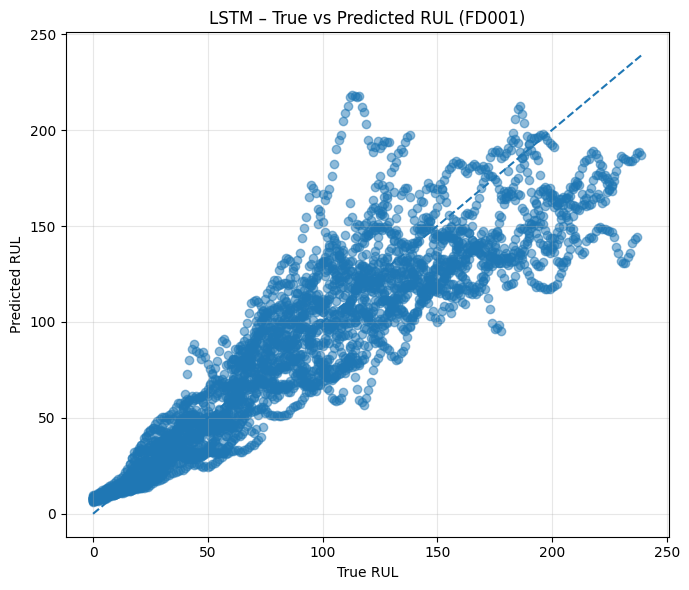

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


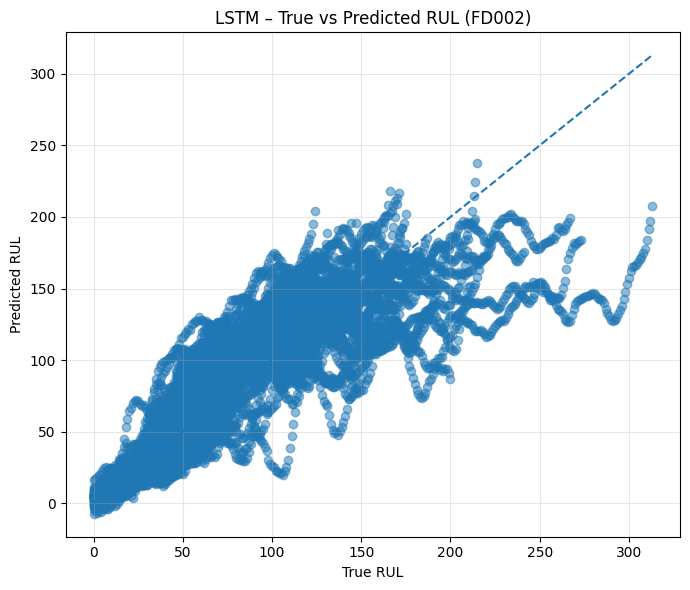

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


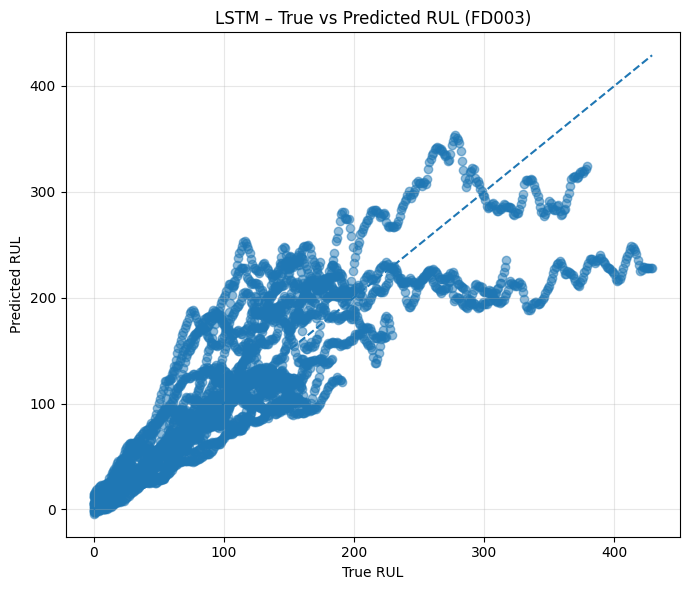


=== LSTM results ===
{'scenario': 'FD001', 'n_features': 14, 'MAE': 18.29837417602539, 'RMSE': 25.417156810933093, 'R2': 0.8095781803131104}
{'scenario': 'FD002', 'n_features': 17, 'MAE': 21.92925262451172, 'RMSE': 30.927353923398055, 'R2': 0.7234741449356079}
{'scenario': 'FD003', 'n_features': 15, 'MAE': 31.915611267089844, 'RMSE': 46.46169352104753, 'R2': 0.7176609039306641}


In [ ]:
lstm_001 = eval_lstm_scenario(df_train,  "FD001", keep_001, window=30, plot=True)
lstm_002 = eval_lstm_scenario(df_train2, "FD002", keep_002, window=30, plot=True)
lstm_003 = eval_lstm_scenario(df_train3, "FD003", keep_003, window=30, plot=True)

print("\n=== LSTM results ===")
print(lstm_001)
print(lstm_002)
print(lstm_003)


##  Interpretation of the Results

### Overall performance comparison

The table below summarizes the performance of the three models across the three C-MAPSS scenarios.

| Scenario | Model | MAE | RMSE  | R² |
|--------|------|-------|--------|------|
| FD001 | Gradient Boosting | 25.05 | 34.82 | 0.719 |
|       | Random Forest     | 25.24 | 35.91 | 0.701 |
|       | **LSTM**           | **18.30** | **25.42** | **0.810** |
| FD002 | Gradient Boosting | 32.49 | 41.31 | 0.606 |
|       | Random Forest     | 31.51 | 40.65 | 0.618 |
|       | **LSTM**           | **21.93** | **30.93** | **0.723** |
| FD003 | Gradient Boosting | 39.94 | 59.70 | 0.585 |
|       | Random Forest     | 38.06 | 57.74 | 0.612 |
|       | **LSTM**           | **31.92** | **46.46** | **0.718** |



### Scenario-wise analysis

#### FD001 — Single operating condition, single fault mode
Gradient Boosting and Random Forest achieve reasonable performance, with R² values around 0.70.  
However, the LSTM clearly outperforms both classical models, achieving approximately a **27% reduction in MAE** and a higher R² (0.81).  
This indicates that even in simple degradation settings, **temporal information plays a critical role**.



#### FD002 — Multiple operating conditions
The presence of multiple operating conditions increases the complexity of the problem.  
Tree-based models struggle to disentangle operational variability from true degradation signals, resulting in lower R² values (~0.61).  
In contrast, the LSTM remains robust, with a **significant reduction in MAE (from ~32 to ~22)** and an R² of 0.72, demonstrating its ability to implicitly learn condition-dependent temporal dynamics.



#### FD003 — Multiple fault modes
FD003 is the most challenging scenario due to the coexistence of multiple degradation mechanisms.  
While Gradient Boosting and Random Forest show limited predictive power (R² ≈ 0.60), the LSTM still achieves strong performance, reducing RMSE by more than **20%** and reaching an R² close to **0.72**.  
This confirms the importance of sequence modeling in complex prognostics settings.



##  Why the models behave differently

### Gradient Boosting & Random Forest
- Treat each sample independently.
- Rely on instantaneous sensor values.
- Perform well as baselines in simple scenarios.
- Require extensive feature engineering (rolling statistics, trends, health indices) to capture degradation dynamics.

### LSTM
- Explicitly models temporal dependencies.
- Learns degradation trends and rates directly from sensor sequences.
- Naturally handles censored trajectories and varying degradation speeds.
- Scales better to complex operating conditions and fault modes.





In [38]:
import pandas as pd

def count_lstm_predictions_per_engine(df_train, window=30):
    """
    Number of LSTM predictions per engine when using a sliding window of length `window`.
    For an engine with T cycles: n_preds = max(0, T - window + 1).
    """
    counts = {}
    for unit, g in df_train.groupby("unit_nr"):
        T = len(g)
        counts[int(unit)] = max(0, T - window + 1)

    s = pd.Series(counts, name="n_predicted_RUL").sort_index()

    summary = {
        "n_engines": int(s.shape[0]),
        "min_preds_per_engine": int(s.min()),
        "max_preds_per_engine": int(s.max()),
        "mean_preds_per_engine": float(s.mean()),
        "median_preds_per_engine": float(s.median()),
        "total_predictions": int(s.sum()),
    }
    return summary, s


# --- Run for the 3 scenarios ---
sum_001, details_001 = count_lstm_predictions_per_engine(df_train,  window=30)
sum_002, details_002 = count_lstm_predictions_per_engine(df_train2, window=30)
sum_003, details_003 = count_lstm_predictions_per_engine(df_train3, window=30)

print("\n=== LSTM predicted RUL counts per engine (window=30) ===")
print("FD001 summary:", sum_001)
print("FD002 summary:", sum_002)
print("FD003 summary:", sum_003)






=== LSTM predicted RUL counts per engine (window=30) ===
FD001 summary: {'n_engines': 100, 'min_preds_per_engine': 99, 'max_preds_per_engine': 333, 'mean_preds_per_engine': 177.31, 'median_preds_per_engine': 170.0, 'total_predictions': 17731}
FD002 summary: {'n_engines': 260, 'min_preds_per_engine': 99, 'max_preds_per_engine': 349, 'mean_preds_per_engine': 177.76538461538462, 'median_preds_per_engine': 170.0, 'total_predictions': 46219}
FD003 summary: {'n_engines': 100, 'min_preds_per_engine': 116, 'max_preds_per_engine': 496, 'mean_preds_per_engine': 218.2, 'median_preds_per_engine': 191.5, 'total_predictions': 21820}


## Impact of temporal windowing on LSTM performance

Using a window length of 30 cycles, each engine trajectory is decomposed into multiple overlapping temporal sequences. This results in a significantly larger number of effective training samples per engine:

| Scenario | Mean predictions per engine | Total predictions |
|---------|-----------------------------|-------------------|
| FD001 | 177 | 17,731 |
| FD002 | 178 | 46,219 |
| FD003 | 218 | 21,820 |

##  Analysis of prediction distribution

The analysis of prediction counts per engine highlights notable differences in the temporal structure of the three scenarios.

For FD001, each engine generates on average approximately **177 predictions**, with a relatively narrow range between minimum and maximum values. This indicates homogeneous engine lifetimes and a balanced distribution of degradation trajectories across the dataset. The proximity between the mean and median further suggests limited skewness.

In FD002, the average number of predictions per engine remains comparable to FD001. However, due to the larger number of engines, the total number of predictions is significantly higher. This reflects a broader coverage of operating conditions while maintaining similar average trajectory lengths.

FD003 stands out with a higher average number of predictions per engine (approximately **218**), as well as a wider range of values. The difference between the mean and median indicates a right-skewed distribution, driven by a subset of engines with substantially longer lifetimes. These longer trajectories contribute disproportionately to the total number of predictions.

Overall, these results show that the scenarios differ not only in terms of operating conditions and fault complexity, but also in the **distribution and length of available degradation trajectories**, which directly affects the amount of temporal information present in each dataset.






## Conclusion

This study evaluated Remaining Useful Life (RUL) prediction across the three C-MAPSS scenarios using **Gradient Boosting**, **Random Forest**, and **LSTM**, with a consistent experimental protocol applied to all models.

### Experimental setting and rationale
All models were trained and evaluated **exclusively on the training datasets (`df_train`)**, using a group-based split by engine. The true RUL was computed directly from the training data as the difference between the maximum cycle and the current cycle for each engine.  
This choice ensures:
- a **fair and controlled comparison** across models,
- identical data availability and label definitions,
- and the absence of data leakage from the official test sets.

This setup provides a reliable internal benchmark to analyze model behavior before considering deployment or evaluation on censored test trajectories.


### Summary of observed results
Across all scenarios, the results follow a consistent pattern:
- **FD001** yields the best performance,
- **FD002** shows a clear degradation in accuracy,
- **FD003** is the most challenging scenario, with the highest errors and lowest explained variance.

This progression reflects the increasing complexity of the scenarios, from a single operating condition and fault mode to multiple operating conditions and multiple degradation mechanisms.



### Interpretation across models
Tree-based models (Gradient Boosting and Random Forest) achieve comparable performance within each scenario. Their errors increase steadily from FD001 to FD003, indicating growing difficulty in capturing the underlying degradation process as variability increases. Despite this, they remain strong baselines and provide stable, interpretable results when trained on cycle-level data.

The LSTM consistently outperforms both tree-based approaches across all scenarios. This improvement is not incidental, but structurally linked to the way the data is exploited. By operating on sliding windows, the LSTM generates **hundreds of training samples per engine**, whereas classical models rely on independent cycle-level observations. As a result, the LSTM benefits from:
- a much larger effective training set,
- direct access to temporal continuity,
- and the ability to learn degradation trends rather than isolated sensor states.



### Linking performance to data structure
The analysis of prediction counts per engine provides a key explanatory factor. With a window size of 30 cycles, each engine contributes on average:
- 177 prediction samples in FD001,
- 178 in FD002,
- 218 in FD003.

These differences reveal that scenario difficulty is not only driven by operating conditions and fault diversity, but also by the **length and heterogeneity of engine trajectories**. FD003, while offering longer trajectories on average, exhibits higher variability, which increases uncertainty despite richer temporal information.



### Final perspective
Taken together, the results show that:
- Performance differences across scenarios are primarily driven by **intrinsic data complexity**.
- Performance differences across models are explained by **how effectively each model leverages temporal information**.
- Using only `df_train` for each scenario provides a consistent and scientifically sou_
